<a href="https://colab.research.google.com/github/eduardokern/ML/blob/main/notebooks/transfer-learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning (BairesDev treinamento ML)

O projeto consiste em aplicar o método de Transfer Learning em uma rede de Deep Learning na linguagem Python no ambiente COLAB.  

Para exemplo, utilizaremos o seguinte projeto que realiza Transfer Learning com o Dataset do MNIST:
https://colab.research.google.com/github/kylemath/ml4a-guides/blob/master/notebooks/transfer-learning.ipynb

O dataset utilizado engloba duas classes: gatos e cachorros. Uma descrição da base de dados pode ser visualizada neste link: https://www.tensorflow.org/datasets/catalog/cats_vs_dogs.

Já o dataset para download pode ser acessado por meio deste outro link:

https://www.microsoft.com/en-us/download/details.aspx?id=54765.

Observações: Neste projeto, você pode usar sua própria base de dados (exemplo: fotos suas, dos seus pais, dos seus amigos, dos seus animais domésticos, etc), o exemplo de gatos e cachorros, pode ser substituído por duas outras classes do seu interesse. O Dataset criado em nosso projeto anterior, pode ser utilizado agora.  

O projeto deve ser enviado para o GitHub da DIO: https://github.com/digitalinnovationone.


### Baixando o dataset

Será utilizado o dataset [Kaggle Cats and Dogs](https://www.microsoft.com/en-us/download/details.aspx?id=54765) a ser baixado pelo comando:

    curl -L -o kagglecatsanddogs_5340.zip --progress-bar https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
    unzip kagglecatsanddogs_5340.zip

In [5]:
!echo "Downloading kagglecatsanddogs_5340.zip for image notebooks"
!curl -L -o kagglecatsanddogs_5340.zip --progress-bar https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!echo "Extracting images..."
!rm -rf PetImages
!unzip -qo kagglecatsanddogs_5340.zip
!rm kagglecatsanddogs_5340.zip
!echo "Done."


############################################################################################# 100.0%
Extracting images...
Done.


### Python imports

Importando pacotes e módulos necessários para implementação do <b>Transfer Learning</b> com `keras`

Para visualização das imagens é importado o pacote `matplotlib`

In [54]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

### Categorias de imagens

Identificando a categoria das imagens a serem classificadas. Cada categoria está identificada em uma pasta diferente, utilizando o nome da pasta como categoria de imagem.

In [55]:
root = 'PetImages'
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]

print(categories)

['PetImages/Dog', 'PetImages/Cat']


### Função get_image

A função abaixo carrega e pré processa uma image a ser utilizada no restante do projeto.

Mantendo a razão de aspecto da imagem uma vez que podem não ter a altura e largura idênticas.

A função `preprocess_input` é utilizada para padronizar e normalizar os dados de imagem, principalmente para utilizar em modelos pré treinados cujos consjuntos de treinamento seguiram o mesmo tipo de preprocessamento. Isto garante consistência e melhor resultado no desempenho do novo modelo.

In [56]:
# helper function to load image and return it and input vector
def get_image(path):
  try:
    img = image.load_img(path, target_size=(224, 224), keep_aspect_ratio=True)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x
  except Exception as e:
    print(f'Error loading: {path}')
    return None, None

### Carregar imagens

O dataset contém cerca de 5000 imagens de cada categoria.
A máquina utilizada não dispõe de recurso para carregar todo o dataset, limitando a 1000 imagens (samples) de cada categoria.

As imagens são carregas a partir da pasta `root`.

Armazenando o caminho das imagens para apresnetação dos resultados.

In [57]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    idx = [int(len(data) * random.random()) for i in range(1000)]
    for img_path in images[:1000]:
        img, x = get_image(img_path)
        if img is not None:
          data.append({'x':np.array(x[0]), 'y':c, 'path': img_path})

# count the number of classes
num_classes = len(categories)

Error loading: PetImages/Dog/11702.jpg


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Error loading: PetImages/Cat/666.jpg


### Gerando imagens em ordem aleatória

Alterando a ordem das imagens de forma aleatória para se ter um conjunto de dados diferente a cada rodada e contendo dados alternadaos de cada categoria.

In [58]:
random.shuffle(data)

### Dataset de treinamento, validação e testes

- Treinamento: 70%,
- Validação: 15%,
- Testes: 15%

In [59]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

## Separando os dados e rótulos

Criando um `array` diferente para os dados e os labels, seguindo a mesma ordenação no array original.

In [60]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0]


### Preprocessamento

- Garantir que é do tipo `float32` e está normalizado entre -1 e 1.
- Converter o array de labels para um `hot vector`.

In [61]:
# normalize data
x_train = x_train.astype('float32') /255.
x_val = x_val.astype('float32') /255.
x_test = x_test.astype('float32') /255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(300, 2)


### Resumo dos dados de treinamento

In [62]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)


finished loading 1998 images from 2 categories
train / validation / test split: 1398, 300, 300
training data shape:  (1398, 224, 224, 3)
training labels shape:  (1398, 2)


### Visualização de algumas imagens do dataset

Se tudo correu da forma esperado neste ponto teremos as imagens carregadas e preprocessadas para o treinamento, validação e teste.

A seguir é apresentada a visualização de algumas imagens do dataset.

(-0.5, 1791.5, 223.5, -0.5)

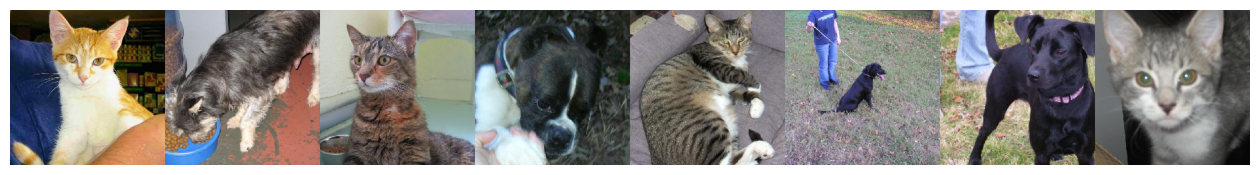

In [63]:
imgs = [image.load_img(data[i]['path'], target_size=(224, 224), keep_aspect_ratio=True) for i in range(8)]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)
plt.axis('off')

### Treinando uma rede do zero

Antes de fazer o `Transfer Learning` será feito o treinamento de uma rede sem qualquer peso de conhecimentos prévios. O objetivo é ter um resultado prévio para os mesmos dados e comparar com o resultado da rede gerada pelo `Transfer Learning`.  

A rede contém 4 camadas convolucionais alternadas e max-pooling, seguida por um [dropout](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf) após cada outro par conv/pooling. Após a última camada pooling, é anexada uma camada totalmente conectada de 256 neurônios, outra camada dropout, e finalmente uma camada de classificação softmax para as categorias.

A função `loss` será, comom de costume, `categorical cross-entropy loss`, e o algoritmos de treinamento será o [AdaDelta](https://arxiv.org/abs/1212.5701).

A rede pode ser alterada para obtenção de melhor performance, entretanto para o propósito deste projeto o objetivo é obter conhecimento para um ponto de partida para comparação.

Após a compilação da rede executaremos `model.summary()` para pmostrar um snapshot de suas camadas.

In [64]:
# build the network
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 222, 222, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 109, 109, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 109, 109, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 52, 52, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 52, 52, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 24, 24, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2)                   │             514 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,209,058 (4.61 MB)

 Trainable params: 1,209,058 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

Foi criada uma rede de tamanho médio com ~1.2 milhões de pesos e biases (os parâmetros). A maioria deles leva a uma camada totalmente conectada pre-softmax "dense_5".

Agora é possível seguir para o treinamento do modelo para 10 épocas com um tamanho de lote de 128.

O histórico do treinamento será salvo para visualização do valor de `loss` ao longo do tempo.

In [65]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))


Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 608ms/step - accuracy: 0.4965 - loss: 0.6958 - val_accuracy: 0.5000 - val_loss: 0.6907
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 0.5506 - loss: 0.6867 - val_accuracy: 0.5700 - val_loss: 0.6595
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.6253 - loss: 0.6329 - val_accuracy: 0.6367 - val_loss: 0.6437
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.6413 - loss: 0.6274 - val_accuracy: 0.6233 - val_loss: 0.6311
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - accuracy: 0.6715 - loss: 0.5923 - val_accuracy: 0.6367 - val_loss: 0.6240
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.6907 - loss: 0.5787 - val_accuracy: 0.6000 - val_loss: 0.6484
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.7046 - loss: 0.5537 - val_accuracy: 0.6567 - val_loss: 0.6026
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.7469 - loss: 0.5042 - val_accuracy: 0

Agora é apresentado os gráfico de `loss` e  `validation accuracy` ao longo do tempo.[texto do link](https://)

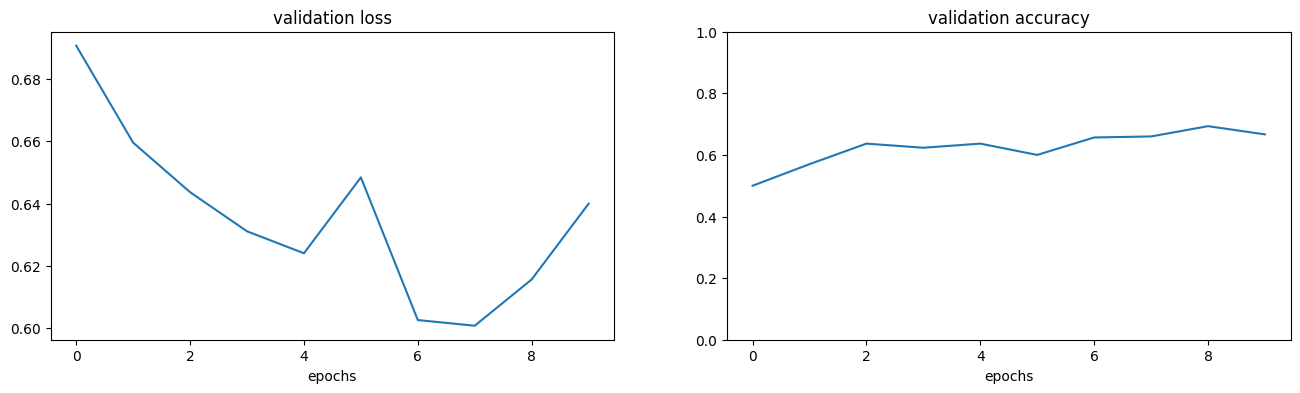

In [66]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

A `validation accuracy` permanece em torno de 65%.

O próxima etapa é realizar uma avaliação final executando o modelo sobre o conjunto de validação, alcançando os resultados abaixo:

In [67]:
loss, accuracy = model.evaluate(x_val, y_val, verbose=0)
print('Validation loss:', loss)
print('Validation accuracy:', accuracy)

Validation loss: 0.6399493217468262
Validation accuracy: 0.6666666865348816


Finalmente, pode ser observado que obteve-se uma (top-1) exatidão em torno de 65%. quer não é tão ruim para 1400 imagens, considerando que utilizando uma estratégia ingênua de palpites aleatórios, seria obtido uma exatidão em torno de somento 1%.

## Transfer learning a partir de uma rede existente

Agora é possível seguir com a estratégia principal de treinamento de um classificador para o dataset em questão: iniciar uma rede maior e já treinada.

Para iniciar será carregada a rede `VGG16` do `keras`, que foi treinada com o ImageNet e os pesos salvos online. uma vez que a rede é carregada, é possivel novamente inspecionar as camadas com o método `summary()`.

In [68]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

É possível notar que a rede `VGG16` é <b>_muito_</b> maior que a rede anterior. Contém 13 camadas convolucionais e duas camadas totalmente conectadas ao final, e tendo mais de 138 milhões de parâmetros, cerca de 100 mais que a rede construída anteriormente. Como a rede anterior, a maioria dos parâmetros estão armazenados nas conexões levando a primeira camada totalmente conectada.

Para utilizar esta rede no projeto, será <b>"removida"</b> a camada de classificação final, a camada softmax com 100 neurônios ao final, que corresponde as categorias da ImageNet. No lugar será adicionada uma nova camada softmax para a quantidade de categorias do dataset em questão, 2 (cachorros e gatos).

In [69]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)


Próximo passo é retreinar a rede `model_new` com o dataset e rótulos em questão. Porém primeio, é necessário congelar os pesos e  biases em todas as camadas da rede, com exceção da nova camada adicionad ao final, com a expectativa de que as características aprendidas na `VGG` permaneçam significantemente relevantes para a nova classificação de imagens. Não é o ótimo, porém muito melhor do que treinando do zero com o dataset limitado em questão.

Especificando a flag `trainable` em cada camada para `false` (com exceção da nova camada de classificação ), os pesos e biases permanece fixos

Após a compilação da rede modificada, executamos `summary` novamente para verificar a arquitetura da rede.

In [70]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "functional_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 8,194 (32.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

Avaliando o resumo, verificamos que a rede permanece idêntica com o modelo `VGG` com exceção da última camada que agora apresenta apenas 2 neurônios. Além disto, apresenta 134 milhões de pesos, porém a maioria são "parâmetros não treinados" por conta das camadas congeladas. Tem-se apenas 397.000 parâmetros treináveis, que é apenas um quarto dos parâmetros necessários para a rede do zero.

Para o treinamento preservou-se os mesmo patrâmetros (tamanho de lote e números de épocas) e o mesmo algorítmo de otimização.

In [71]:
history2 = model_new.fit(x_train, y_train,
                         batch_size=128,
                         epochs=10,
                         validation_data=(x_val, y_val))


Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5650 - loss: 0.8493 - val_accuracy: 0.7933 - val_loss: 0.5324
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 657ms/step - accuracy: 0.7755 - loss: 0.5108 - val_accuracy: 0.8067 - val_loss: 0.4428
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 671ms/step - accuracy: 0.8687 - loss: 0.3973 - val_accuracy: 0.8467 - val_loss: 0.3800
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 690ms/step - accuracy: 0.8982 - loss: 0.3430 - val_accuracy: 0.8700 - val_loss: 0.3459
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 799ms/step - accuracy: 0.8959 - loss: 0.3091 - val_accuracy: 0.8733 - val_loss: 0.3271
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 661ms/step - accuracy: 0.9038 - loss: 0.2875 - val_accuracy: 0.8633 - val_loss: 0.3227
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 666ms/step - accuracy: 0.8989 - loss: 0.2692 - val_accuracy: 0.8833 - val_loss: 0.2995
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 663ms/step - accuracy: 0.9174 - loss: 0.2530 - val_accuracy


A `validation accuracy` chega a 92% ao final, o que representa um incremento de 42% em relação a rede do zero (significando que é feito a classificação errada em 8% das amostras ao invés de 35%).

A seguir são apresentados os gráficos de `loss` e `validation accuracy` para a rede do zero (azul) e a com transfer learning (laranja) para função de comparação dos resultados.

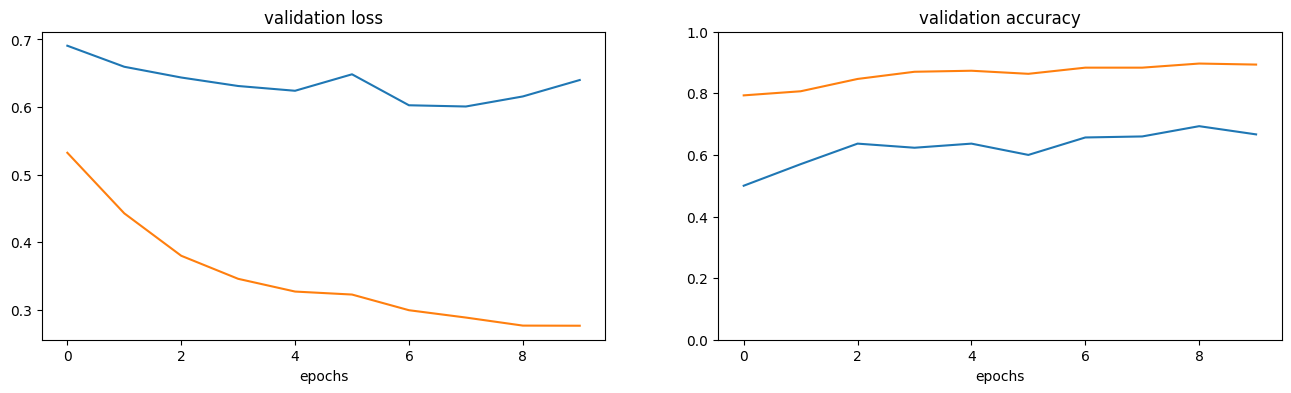

In [72]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Novamente uma validação final com o conjunto de validação

In [73]:
loss, accuracy = model_new.evaluate(x_val, y_val, verbose=0)

print('Validation loss:', loss)
print('Validation accuracy:', accuracy)

Validation loss: 0.27657023072242737
Validation accuracy: 0.8933333158493042


To predict a new image, simply run the following code to get the probabilities for each class.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


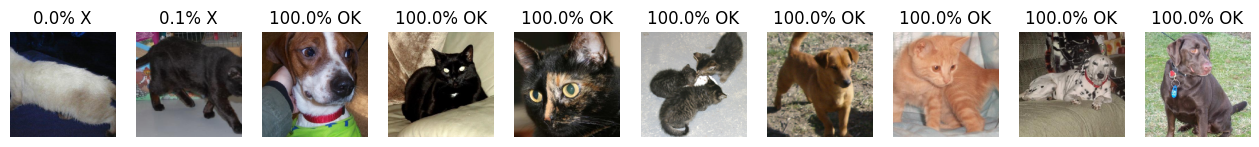

In [74]:
fig, axs = plt.subplots(1, 10, figsize=(16, 4))
idx = [int(len(test) * random.random()) for i in range(10)]
for ax, i in enumerate(idx):
  img = image.load_img(test[i]['path'], target_size=(224, 224), keep_aspect_ratio=True)
  data = test[i]['x']
  cat = test[i]['y']
  probabilities = model_new.predict(np.array([data]))
  prob = probabilities[0][cat]
  status = 'OK' if prob > 0.5 else 'X'
  axs[ax].imshow(img)
  axs[ax].set_title(f'{prob*100:.1f}% {status}')
  axs[ax].axis('off')
